In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()
print(x)

[0.35237491 4.8951233  1.86662437 3.50706129 3.38087384 0.73093728
 3.88562366 5.65224803 6.28318531 2.37137419 0.60474982 3.63324875
 0.85712473 2.49756165 1.61424946 5.39987312 6.15699785 6.0308104
 0.47856237 2.87612401 4.51656093 0.98331219 1.10949964 0.1
 2.11899928 1.36187455 4.01181111 5.77843549 4.26418602 1.2356871
 2.24518674 1.99281183 1.48806201 4.64274839 4.39037348 3.00231147
 0.22618746 5.27368567 5.02131076 5.52606058 2.6237491  4.76893584
 3.12849893 1.74043692 3.7594362  3.25468638 5.90462294 4.13799857
 2.74993656 5.14749821]


In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    if k+1 < len(k_indices):
        train_indices = np.concatenate(list(k_indices[:k]) + list(k_indices[k+1:]))
    else:
        train_indices = np.concatenate(k_indices[:k])
    test_indices = k_indices[k]
    x_train = np.take(x, train_indices)
    x_test = np.take(x, test_indices)
    
    y_train = np.take(y, train_indices)
    y_test = np.take(y, test_indices)

    # form data with polynomial degree
    x_train = build_poly(x_train, degree)
    x_test = build_poly(x_test, degree)

    # ridge regression
    # calculate the loss for train and test data
    w, loss_tr = ridge_regression(y_train, x_train, lambda_)
    loss_te = compute_mse(y_test, x_test, w)

    return loss_tr, loss_te

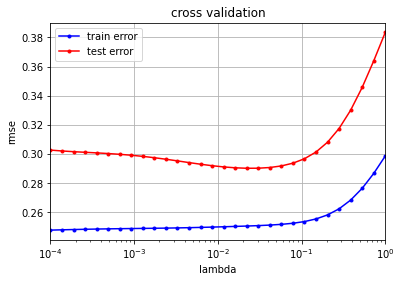

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    for lambda_ in lambdas:
        err_tr = 0
        err_te = 0
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            err_tr += loss_tr
            err_te += loss_te
        err_tr = err_tr/k_fold
        err_te = err_te/k_fold
        rmse_tr.append(np.sqrt(2*err_tr))
        rmse_te.append(np.sqrt(2*err_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

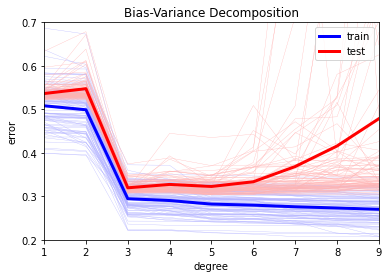

In [13]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        x_train, x_test, y_train, y_test = split_data(x, y, ratio_train, seed=seed)
        
        for index_degree, degree in enumerate(degrees):
            x_train_p = build_poly(x_train, degree)
            x_test_p = build_poly(x_test, degree)
            weights, train_mse = least_squares(y_train, x_train_p)
            test_mse = compute_mse(y_test, x_test_p, weights)
            
            train_rmse = np.sqrt(2*train_mse)
            test_rmse = np.sqrt(2*test_mse)
            
            rmse_tr[index_seed, index_degree] = train_rmse
            rmse_te[index_seed, index_degree] = test_rmse

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()